

# Fig 3 options

1. balls per age group (same info as Fig 2b)
2. something separating urban vs. rural
3. CDF or similar showing most/least affected
4. WBGTi in T,qs space
5. Conceptual figure on distributions changing in a specific spot (get eCDF from models and theoretical distr from reanalysis and cfr with reanalysis 10 years distribution changing in space - for a given month)
6. Something with some regional information

Luthi code for balls: 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as mpimg
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm
%matplotlib inline 
plt.rcdefaults()

import numpy as np
import pandas as pd

# import fxns 
from functions_ana import *
from utils_ana import *
from plotscript import *

# import other packages/modules 
sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/')) #hpc
from population_demographics import * 

## Petri dish: Functions

In [2]:
'''------------------------------------------------------------------------'''
''' Plot petridish '''

class Point:
    """A little class representing an SVG circle."""

    def __init__(self, cx, cy, r, icolour=None):
        """Initialize the circle with its centre, (cx,cy) and radius, r.

        icolour is the index of the circle's colour.

        """
        self.cx, self.cy, self.r = cx, cy, r
        self.icolour = icolour

    def overlap_with(self, cx, cy, r):
        """Does the circle overlap with another of radius r at (cx, cy)?"""

        d = np.hypot(cx-self.cx, cy-self.cy)
        return d < r + self.r

class PointCloud:
    """A class for drawing circles-inside-a-circle.
    Inspired by https://scipython.com/blog/packing-circles-in-a-circle/
    """

    def __init__(self, width=600, height=600, R=250, n=800, rho_min=0.005,
                 rho_max=0.05, colours=None):
        """Initialize the Circles object.

        width, height are the SVG canvas dimensions
        R is the radius of the large circle within which the small circles are
        to fit.
        n is the maximum number of circles to pack inside the large circle.
        rho_min is rmin/R, giving the minimum packing circle radius.
        rho_max is rmax/R, giving the maximum packing circle radius.
        colours is a list of SVG fill colour specifiers to be referenced by
            the class identifiers c<i>. If None, a default palette is set.

        """

        self.width, self.height = width, height
        self.R, self.n = R, n
        # The centre of the canvas
        self.CX, self.CY = self.width // 2, self.height // 2
        self.rmin, self.rmax = R * rho_min, R * rho_max
        self.colours = colours or ['#993300', '#a5c916', '#00AA66', '#FF9900']

   
    def _place_circle(self, r):
        # The guard number: if we don't place a circle within this number
        # of trials, we give up.
        guard = 500
        while guard:
            # Pick a random position, uniformly on the larger circle's interior
            cr, cphi = ( self.R * np.sqrt(np.random.random()),
                         2*np.pi * np.random.random() )
            cx, cy = cr * np.cos(cphi), cr * np.sin(cphi)
            if cr+r < self.R:
            # The circle fits inside the larger circle.
                if not any(circle.overlap_with(self.CX+cx, self.CY+cy, r)
                                    for circle in self.circles):
                    # The circle doesn't overlap any other circle: place it.
                    circle = Point(cx+self.CX, cy+self.CY, r,
                                icolour=np.random.randint(len(self.colours)))
                    self.circles.append(circle)
                    return
            guard -= 1
        # Warn that we reached the guard number of attempts and gave up for
        # for this circle.
        print('guard reached.')

    def make_circles(self):
        """Place the little circles inside the big one."""

        # First choose a set of n random radii and sort them. We use
        # random.random() * random.random() to favour small circles.
        self.circles = []
        r = self.rmin + (self.rmax - self.rmin) * np.random.random(
                                self.n) * np.random.random(self.n)
        r[::-1].sort()
        # Do our best to place the circles, larger ones first.
        for i in range(self.n):
            self._place_circle(r[i])








In [3]:



def plot_petri_dish(impacts, return_period, location, model='Median', title='',
                    sort_points=False):
    
    wl=np.array([1.2, 1.5, 2.0])
    wl_name = ['Risk 2000', 'Risk 2020', 'Risk 1.5$^\circ$C', 'Risk 2.0$^\circ$C']  

    col_lvls, al_lvls = prep_data_petri_dish(impacts, return_period,
                                                 location, model, wl)
    
    fig, axes = plt.subplots(1, 4, figsize = (24, 6))
    plt.rcParams.update({'font.family':'arial'})
    plt.suptitle(title, fontsize=44)
    

    for w, wlevel in enumerate(wl_name):
        cloud = PointCloud(width=100, height=100, R=50, n=100, rho_min=0.065,
                     rho_max=0.065)
        cloud.make_circles()
        while len(cloud.circles)<100:
            cloud = PointCloud(width=100, height=100, R=50, n=100, rho_min=0.065,
                         rho_max=0.065)
            cloud.make_circles()
        cx = np.zeros(100)
        cy = np.zeros(100)
        for j in range(100):
            cx[j] = cloud.circles[j].cx
            cy[j] = cloud.circles[j].cy
        if sort_points:
            r = (cx-50.)**2+(cy-50)**2
            r_ind = 99-np.argsort(r.argsort())
            col = []
            al = []
            for i in r_ind:
                col.append(col_lvls[w][i])
                al.append(al_lvls[w][i])
        else:
            col = col_lvls[w]
            al = al_lvls[w]
        circle = Circle((50, 50), 50, facecolor='none',
                        edgecolor='black', linewidth=1, alpha=1)
    
        axes[w].scatter(cx, cy, s=400, marker='o', c=col, alpha=al)
        axes[w].add_patch(circle)
        axes[w].get_xaxis().set_visible(False)
        axes[w].get_yaxis().set_visible(False)
        axes[w].axis('off')
        axes[w].set_title(wlevel, fontsize=32)   
    plt.subplots_adjust(left=0.15,
                    bottom=0.1, 
                    right=0.85, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.1)
    
    cm = plt.get_cmap('inferno_r')
    cols = [cm(i / 10) for i in range(10)]
    
    # p1 = plt.scatter(np.NaN, np.NaN, color=cols[1], s=400, marker='o')
    p2 = plt.plot(np.NaN, np.NaN, color=cols[3], markersize=20, marker='o', linestyle='')
    p3 = plt.plot(np.NaN, np.NaN, color=cols[6], markersize=20, marker='o', linestyle='')
    p4 = plt.plot(np.NaN, np.NaN, color=cols[9], markersize=20, marker='o', linestyle='')



    plt.legend([p2[0],p3[0], p4[0]],
               ['1-in-10 year season in 2000',
                '1-in-100-year season in 2000',
                '1-in-500-year season in 2000'],
               bbox_to_anchor=(-1.1, -0.25), loc='lower center', ncol=3,
               fontsize=24, frameon=False) 
    plt.show()



# plot_petri_dish(impacts, return_period, location=locations[10], model='Median', title='')
# plot_petri_dish(impacts, return_period, location=locations[10], model='Median', title='', sort_points=True)

# for c in locations:
#     plot_petri_dish(impacts, return_period, location=c, model='Median', title=c, sort_points=True)



## Testing 

## Plot

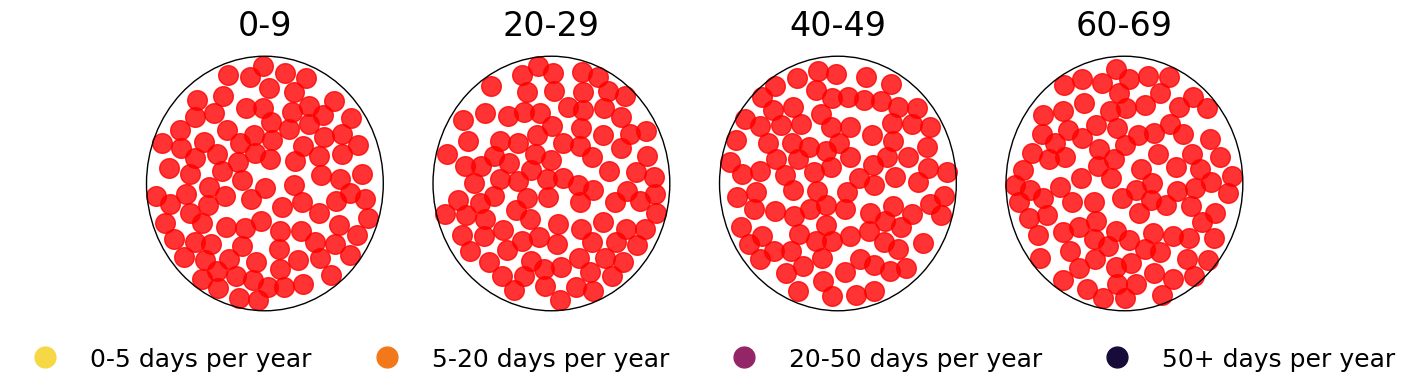

In [5]:

# Parameters
title = ''
sort_points = False

wl = np.array([1.2, 1.5, 2.0])
wl_name = ['0-9', '20-29', '40-49', '60-69']

# Create the figure and axes with smaller size
fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # Adjusted figsize to (16, 4)
plt.suptitle(title, fontsize=32)  # Reduced font size for title

for w, wlevel in enumerate(wl_name):
    cloud = PointCloud(width=100, height=100, R=50, n=100, rho_min=0.065,
                       rho_max=0.065)
    cloud.make_circles()
    
    while len(cloud.circles) < 100:
        cloud = PointCloud(width=100, height=100, R=50, n=100, rho_min=0.065,
                           rho_max=0.065)
        cloud.make_circles()
        
    cx = np.zeros(100)
    cy = np.zeros(100)
    for j in range(100):
        cx[j] = cloud.circles[j].cx
        cy[j] = cloud.circles[j].cy
        
    if sort_points:
        r = (cx - 50.) ** 2 + (cy - 50) ** 2
        r_ind = 99 - np.argsort(r.argsort())
        col = [col_lvls[w][i] for i in r_ind]
        al = [al_lvls[w][i] for i in r_ind]
    else:
        col ='red'  # col_lvls[w]# 
        al = .8  # al_lvls[w]#
        
    circle = Circle((50, 50), 50, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1)

    axes[w].scatter(cx, cy, s=200, marker='o', c=col, alpha=al)  # Reduced marker size
    axes[w].add_patch(circle)
    axes[w].get_xaxis().set_visible(False)
    axes[w].get_yaxis().set_visible(False)
    axes[w].axis('off')
    axes[w].set_title(wlevel, fontsize=24)  # Reduced font size for titles

plt.subplots_adjust(left=0.15,
                    bottom=0.1, 
                    right=0.85, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.1)

cm = plt.get_cmap('inferno_r')
cols = [cm(i / 10) for i in range(10)]

p1 = plt.plot(np.NaN, np.NaN, color=cols[1], markersize=15, marker='o', linestyle='')  # Reduced marker size
p2 = plt.plot(np.NaN, np.NaN, color=cols[3], markersize=15, marker='o', linestyle='')  # Reduced marker size
p3 = plt.plot(np.NaN, np.NaN, color=cols[6], markersize=15, marker='o', linestyle='')  # Reduced marker size
p4 = plt.plot(np.NaN, np.NaN, color=cols[9], markersize=15, marker='o', linestyle='')  # Reduced marker size

plt.legend([p1[0], p2[0], p3[0], p4[0]],
           ['0-5 days per year',
            '5-20 days per year',
            '20-50 days per year',
           '50+ days per year'],
           bbox_to_anchor=(-1.1, -0.25), loc='lower center', ncol=4,
           fontsize=18, frameon=False)  # Reduced font size for legend
plt.show()


In [6]:

# def prep_data_petri_dish(impacts, return_period, location, model, wl): # OLD VERSION 
#     cm = plt.get_cmap('inferno_r')
#     cols = [cm(i / 10) for i in range(10)]

#     # make colors for petri dishes
#     c = np.arange(0,100,1); col_lvls = dict(); al_lvls = dict()

#     # base
#     # al = []; col = []
#     # for j in c:
#     #     if j < 90: col.append(cols[1]); al.append(0.4)
#     #     elif j < 99: col.append(cols[3]); al.append(0.6)
#     #     else: col.append(cols[6]); al.append(0.8)
#     # col_lvls[0] = col
#     # al_lvls[0] = al

#     for w, wlevel in enumerate(wl):
#         c_10 = change_in_RP(10, return_period[model], impacts[model][location][str(0.7)][0,:],
#                                               return_period[model], impacts[model][location][str(wlevel)][0,:])
#         c_100 = change_in_RP(100, return_period[model], impacts[model][location][str(0.7)][0,:],
#                                                return_period[model], impacts[model][location][str(wlevel)][0,:])
#         c_500 = change_in_RP(500, return_period[model],impacts[model][location][str(0.7)][0,:],
#                                                 return_period[model], impacts[model][location][str(wlevel)][0,:])
#         al = []; col = []
#         for j in c:
#             if j < 100-np.round(1/c_10*100): col.append(cols[1]); al.append(0.4)
#             elif j < 100-np.round(1/c_100*100): col.append(cols[3]); al.append(0.6)
#             elif j < 100-np.round(1/c_500*100): col.append(cols[6]); al.append(0.8)
#             else: col.append(cols[9]); al.append(1)
    
#         col_lvls[w+1] = col
#         al_lvls[w+1] = al
        
#     return col_lvls, al_lvls

In [7]:
def prep_data_petri_dish(impacts, return_period, model, ages): # MY VERSION
    cm = plt.get_cmap('inferno_r')
    cols = [cm(i / 10) for i in range(10)]

    # make colors for petri dishes
    c = np.arange(0,100,1); col_lvls = dict(); al_lvls = dict()


    for i, age in enumerate(ages):
        prop_1_5= .6
        prop_5_20= .2
        prop_20_50= .1
        prop_50= .1

        
        al = []; col = []
        for j in c:
            if j < 100-np.round(prop_1_5*100): col.append(cols[1]); al.append(0.4)
            elif j < 100-np.round(prop_5_20*100): col.append(cols[3]); al.append(0.6)
            elif j < 100-np.round(prop_20_50*100): col.append(cols[6]); al.append(0.8)
            else: col.append(cols[9]); al.append(1)
    
        col_lvls[i] = col
        al_lvls[i] = al
        
    return col_lvls, al_lvls

In [8]:
cm = plt.get_cmap('inferno_r')
cols = [cm(i / 10) for i in range(10)]

# make colors for petri dishes
c = np.arange(0,100,1); col_lvls = dict(); al_lvls = dict()


for i, age in enumerate([0,20,40,60]):
    prop_1_5= .6
    prop_5_20= .2
    prop_20_50= .1
    prop_50= .1

    
    al = []; col = []
    for j in c:
        if j < 100-np.round(prop_1_5*100): col.append(cols[1]); al.append(0.4)
        elif j < 100-np.round(prop_5_20*100): col.append(cols[3]); al.append(0.6)
        elif j < 100-np.round(prop_20_50*100): col.append(cols[6]); al.append(0.8)
        else: col.append(cols[9]); al.append(1)

    col_lvls[i] = col
    al_lvls[i] = al

## Prep data

In [9]:
gs_population_global = population_demographics_gridscale_global(startyear=2023,
                                                                endyear=2023,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [64]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models
x_hot_days = [0, 20, 50, 150]

da_n_people_ndays_models, da_prop_people_ndays_models = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)



da_nAHD_percapita_peopledays_10y_models = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = x_hot_days, 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [65]:
da_prop_people_ndays_models.sel(age_ranges=0).to_pandas().median(axis=0)

# do this for different brackets ! 

features
prop_atleast_0      0.998699
prop_atleast_20     0.622223
prop_atleast_50     0.354393
prop_atleast_150    0.032833
dtype: object

In [66]:
da_prop_people_ndays_models.sel(age_ranges=60).to_pandas().median(axis=0)


features
prop_atleast_0      0.998151
prop_atleast_20      0.44942
prop_atleast_50     0.201737
prop_atleast_150    0.024456
dtype: object

In [67]:
cm = plt.get_cmap('inferno_r')
cols = [cm(i / 10) for i in range(10)]

# make colors for petri dishes
c = np.arange(0,100,1); col_lvls = dict(); al_lvls = dict()

ages = [80,60,40,20,0]

for i, age in enumerate(ages):
    prop_0= da_prop_people_ndays_models.sel(age_ranges=age).to_pandas().median(axis=0)[0]
    prop_1= da_prop_people_ndays_models.sel(age_ranges=age).to_pandas().median(axis=0)[1]
    prop_2= da_prop_people_ndays_models.sel(age_ranges=age).to_pandas().median(axis=0)[2]
    prop_3= da_prop_people_ndays_models.sel(age_ranges=age).to_pandas().median(axis=0)[3]

    print(age, round(prop_0,2), round(prop_1,2), round(prop_2,2), round(prop_3,2))
    
    al = []; col = []
    for j in c:
        if j < np.round(prop_3*100): col.append(cols[9]); al.append(1) 
        elif j < np.round(prop_2*100): col.append(cols[6]); al.append(0.8)
        elif j < np.round(prop_1*100): col.append(cols[3]); al.append(0.6)
        else: col.append(cols[1]); al.append(0.4)

    col_lvls[i] = col
    al_lvls[i] = al

80 1.0 0.35 0.14 0.02
60 1.0 0.45 0.2 0.02
40 1.0 0.52 0.26 0.03
20 1.0 0.59 0.31 0.03
0 1.0 0.62 0.35 0.03


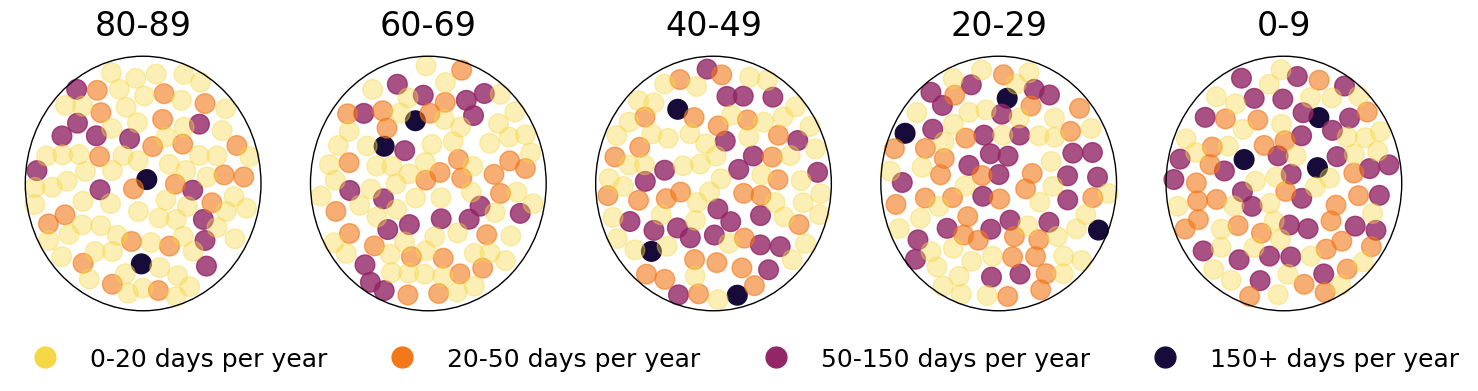

In [68]:

# Parameters
title = ''
sort_points = False

wl = np.array([1.2, 1.5, 2.0])
wl_name = [f'{age}-{age+9}' for age in ages]   # , '20-29', '40-49', '60-69']

# Create the figure and axes with smaller size
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjusted figsize to (16, 4)
plt.suptitle(title, fontsize=32)  # Reduced font size for title

for w, wlevel in enumerate(wl_name):
    cloud = PointCloud(width=100, height=100, R=50, n=100, rho_min=0.065,
                       rho_max=0.065)
    cloud.make_circles()
    
    while len(cloud.circles) < 100:
        cloud = PointCloud(width=100, height=100, R=50, n=100, rho_min=0.065,
                           rho_max=0.065)
        cloud.make_circles()
        
    cx = np.zeros(100)
    cy = np.zeros(100)
    for j in range(100):
        cx[j] = cloud.circles[j].cx
        cy[j] = cloud.circles[j].cy
        
    if sort_points:
        r = (cx - 50.) ** 2 + (cy - 50) ** 2
        r_ind = 99 - np.argsort(r.argsort())
        col = [col_lvls[w][i] for i in r_ind]
        al = [al_lvls[w][i] for i in r_ind]
    else:
        col =col_lvls[w]# 'red'  # 
        al = al_lvls[w]#.8  # 
        
    circle = Circle((50, 50), 50, facecolor='none',
                    edgecolor='black', linewidth=1, alpha=1)

    axes[w].scatter(cx, cy, s=200, marker='o', c=col, alpha=al)  # Reduced marker size
    axes[w].add_patch(circle)
    axes[w].get_xaxis().set_visible(False)
    axes[w].get_yaxis().set_visible(False)
    axes[w].axis('off')
    axes[w].set_title(wlevel, fontsize=24)  # Reduced font size for titles

plt.subplots_adjust(left=0.15,
                    bottom=0.1, 
                    right=0.85, 
                    top=0.8, 
                    wspace=0.1, 
                    hspace=0.1)

cm = plt.get_cmap('inferno_r')
cols = [cm(i / 10) for i in range(10)]

p1 = plt.plot(np.NaN, np.NaN, color=cols[1], markersize=15, marker='o', linestyle='')  # Reduced marker size
p2 = plt.plot(np.NaN, np.NaN, color=cols[3], markersize=15, marker='o', linestyle='')  # Reduced marker size
p3 = plt.plot(np.NaN, np.NaN, color=cols[6], markersize=15, marker='o', linestyle='')  # Reduced marker size
p4 = plt.plot(np.NaN, np.NaN, color=cols[9], markersize=15, marker='o', linestyle='')  # Reduced marker size

plt.legend([p1[0], p2[0], p3[0], p4[0]],
           [f'{x_hot_days[0]}-{x_hot_days[1]} days per year',
            f'{x_hot_days[1]}-{x_hot_days[2]} days per year',
            f'{x_hot_days[2]}-{x_hot_days[3]} days per year',
           f'{x_hot_days[3]}+ days per year'],
           loc='lower center', ncol=4, bbox_to_anchor=(-1.6, -0.25),  #bbox_to_anchor=(-1.1, -0.25)
           fontsize=18, frameon=False)  # Reduced font size for legend
plt.show()


Great ! Edit this to change n days to look a bit better ! More lighter colors